In [3]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
from glob import glob
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import *
import torchvision
from generator import GeneratorRRDB
from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
# from trainer_tune import LitTrainer as LitTrainer_tune
import pytorch_lightning as pl
from discriminator import Discriminator
from feature_extractor import FeatureExtractor
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRSME

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
img_sim = ImagePair(number=100206, simulated=True, select_slices=70)
print(img_sim)
# gen_hr = subject['SR'].numpy()[0]
# gen_hr_nifty = nib.Nifti1Image(gen_hr, affine=img.subject()['HR'].affine, header=img.info()['HR'])
# nib.save(gen_hr_nifty, 'test.nii.gz')

In [3]:
path = 'output/aymen/without'
fname_hr = 'p1_reg_T1_HR'

img_hr = nib.load(os.path.join(path, fname_hr+'.nii.gz'))

img_np_hr = img_hr.get_fdata()
max_val_hr = np.percentile(img_np_hr,95)
img_np_hr = img_np_hr / max_val_hr
print(img_np_hr.max())

2.0869689828673335


In [21]:
path = 'output/aymen/without'
# fname_sr = 'p7_reg_T1-100_SR'
fname_sr = 'p7_reg_T1_SR'

img_sr = nib.load(os.path.join(path, fname_sr+'.nii.gz'))
header_sr = img_sr.header
img_np_sr = img_sr.get_fdata()
max_val_sr = np.percentile(img_np_sr,95)
img_np_sr = img_np_sr / max_val_sr
print(img_np_sr.max())

1.823936807716683


-3485.6083331585255
0.7777797359425254
-0.9939524480498505
0.025891567980201813
-0.0012607090325370825


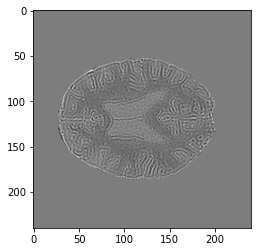

In [5]:
diff = img_np_sr-img_np_hr
plt.imshow(diff[:,:,25], cmap='gray')
diff_sum = np.sum(diff)
diff_std = np.std(diff)

print(diff_sum)
print(diff.max())
print(diff.min())
print(diff_std)
print(diff.mean())

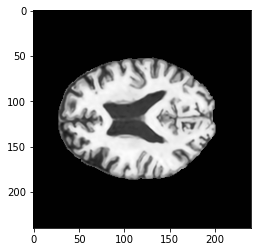

In [6]:
plt.imshow(img_np_sr[:,:,25], cmap='gray')

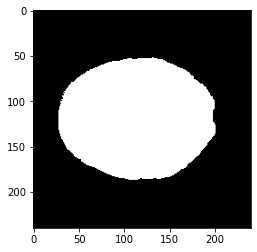

In [7]:
mask = np.ones_like(img_np_sr)
mask[np.where(img_np_sr < 1e-2)] = 0
plt.imshow(mask[:,:,25], cmap='gray')


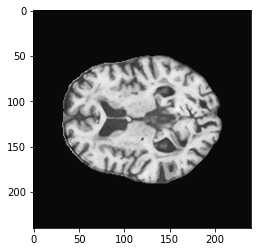

In [22]:
mask = np.ones_like(img_np_sr)
mask[np.where(img_np_sr < 1e-2)] = 0
noise = np.random.normal(loc=0, scale=0.025, size=img_np_sr.shape)
masked_noise = noise*mask
img_np_sr_noise = img_np_sr + masked_noise
plt.imshow(img_np_sr_noise[:,:,25], cmap='gray')
# plt.imshow(masked_noise[:,:,25], cmap='gray')
# plt.imshow(mask[:,:,25], cmap='gray')

In [23]:
img_np_sr_noise *= max_val_sr
affine = np.eye(4)
# affine[2,2] = 2
img_sr_noise = nib.Nifti1Image(img_np_sr_noise, affine=affine, header=header_sr)
nib.save(img_sr_noise, os.path.join(path, fname_sr + '_noise.nii.gz'))

In [177]:
def NCC(real_image, generated_image):
    """Method to compute the normalised cross correlation between two images.
    Arguments:
                real_image:       (numpy array) the real image
                predicted_image:  (numpy array) the predicted image by the model
    Returns:
                NCCScore:         (float) the normalised cross correlation score
    """
    # if the images are not the same size, raise an error
    if real_image.shape != generated_image.shape:
        raise AssertionError("The inputs must be the same size.")
    # reshape images to vectors
    u = real_image.reshape((real_image.shape[0]*real_image.shape[1]*real_image.shape[2],1))
    v = generated_image.reshape((generated_image.shape[0]*generated_image.shape[1]*generated_image.shape[2],1))
    # take the real image and subtract the mean of the real image
    u = u - u.mean(keepdims=True)
    # take the generated image and subtract the mean of the generated image
    v = v - v.mean(keepdims=True)
    # transpose the real image for multiplication
    TransposedU = np.transpose(u)
    # calculate the length of the image
    length = np.linalg.norm(u,ord=2)*np.linalg.norm(v,ord=2)
    # calculate the NCC of the real image and the generated image
    NCCScore = float(TransposedU.dot(v))/length
    # return the NCC score
    return NCCScore

def get_scores(real, gen):
    ncc = NCC(real, gen)
    ssim = SSIM(real, gen, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
    nrmse = NRSME(real, gen)
    return ncc, ssim, nrmse

In [200]:
ncc, ssim, nrmse = get_scores(img_np_hr, img_np_sr)
print('NCC:   {}\nSSIM:  {}\nNRMSE: {}'.format(ncc, ssim, nrmse))

NCC:   0.9988564312713043
SSIM:  0.9907628984591956
NRMSE: 0.04203948322744192
